# CSC2034 Data Science Project --- Wine Quality Analysis
### Jiayuan Zhang 200578334

## Configuration

Before you run this project, you have to do some configuration first.

### Google Colab Setup
This nootbook is designed to be ran using Google Colab. In order to make things work on colab, you need to clone this repo and then move into the repo directory.

You can check the README file in the github repo to find out the files content and some brief instructions.

In [ ]:
!git clone https://github.com/hadjShell/CSC2034_DS.git

Cloning into 'CSC2034_DS'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 3), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
import os
os.chdir('CSC2034_DS')

### Import Libraries

To make the project structure more clear, all libraries, including the helper functions in the repo, you need to run this project are imported at the top. You don't need to figure out all the functions now. You can always come back and check how they works when you encounter them. Here are the docs you may need: [pandas](https://pandas.pydata.org/docs/reference/index.html), [matplotlib](https://matplotlib.org/stable/api/index.html), [seaborn](https://seaborn.pydata.org/api.html), [sklearn](https://scikit-learn.org/stable/modules/classes.html).

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from helpers import discreteAlcohol

In [ ]:
def discreteSugar(df):
    df["isSweet"] = 0
    threshold = df["residual sugar"].median()

    for index, series in df.iterrows():
        sugar = series["residual sugar"]
        if sugar < threshold:
            df.loc[index, "isSweet"] = 0
        else:
            df.loc[index, "isSweet"] = 1


In [ ]:
def plotROC(clf, XTest, QTest, probs=True):
    if (probs == True):
        probs = clf.predict_proba(XTest)
        preds = probs[:,1]
    else:
        preds = clf.decision_function(XTest)
    
    fpr, tpr, threshold = roc_curve(QTest, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Import data

This project is based on two datasets `winequality-red.csv` and `winequality-white.csv`. The two datatests include 4899 and 1600 data points, respectively. Each data point is a set of 12 variables; 11 of these are physicochemical measures, and the last is the perceived quality (sensory output). To have a better understanding on the datasets, you can have a look [here](http://www3.dsi.uminho.pt/pcortez/wine/).

To exploit the datasets more easily, you need to use `pandas` to create a DataFrame object based on the `.csv` files. Most data science packages will be able to handle DataFrames as input. 

In [ ]:
path = './data/'

data_red = pd.read_csv(path + "winequality-red.csv", header=0, sep=';')
data_white = pd.read_csv(path + "winequality-white.csv", header=0, sep=';')

## Exploratory Data Analysis


Before you dive into the project you need to first perform some EDA. This allows you better understand the datasets.

### Quality Distribution

Let's see the distribution of wine quality across all samples, separately for red and white.


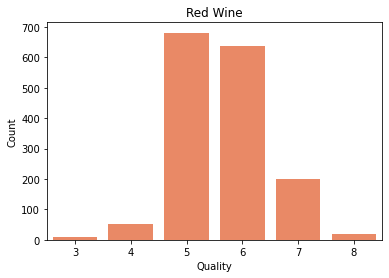

In [ ]:
sns.countplot(data=data_red, x='quality', color='coral')
plt.title("Red Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

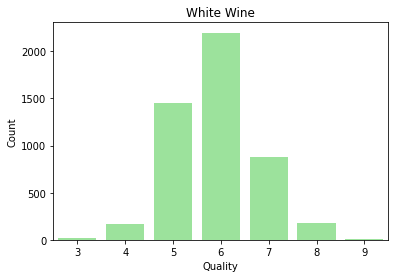

In [ ]:
sns.countplot(data=data_white, x='quality', color='lightgreen')
plt.title("White Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

Now let's take a look at numerical features on the quality and compare them between red wine and white wine.

In [ ]:
display(data_red['quality'].describe())

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [ ]:
display(data_white['quality'].describe())

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

You can see that: 
* Both have similar normal distribution with difference on the 5 and 6 quality items
* White wine has nine quality entities but red wine doesn't
* White wine has higher average quality over red wine

### Discretise Alcohol Content

Let's discretise the alcohol variable into low, mid, and high based on the attribution by creating a new column alcohol_cat, i.e. turn a numerical column to a categorical column. The funtion used here is in the `helpers.py` file.

The `alcohol_cat` variable meets the following conditions:
* low < (average - stddev)
* (average - stddev) < mid < (average + stddev)
* high > (average + stddev)


In [ ]:
discreteAlcohol(data_red)
discreteAlcohol(data_white)

Now have a look at the new column alcohol_cat.

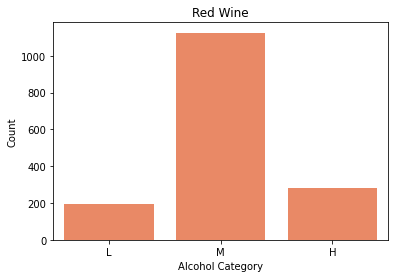

In [ ]:
order = ['L', 'M', 'H']
sns.countplot(data=data_red, x='alcohol_cat', color='coral', order=order)
plt.title("Red Wine")
plt.xlabel("Alcohol Category")
plt.ylabel("Count")
plt.show()
plt.close()

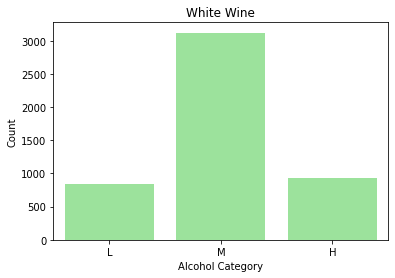

In [ ]:
sns.countplot(data=data_white, x='alcohol_cat', color='lightgreen', order=order)
plt.title("White Wine")
plt.xlabel("Alcohol Category")
plt.ylabel("Count")
plt.show()
plt.close()

### Relationship Between Quality and Alcohol Content

After you discretise alcohol column to three-valued categorical column, you can re-see the distribution of wine quality but seperately for different alcohol content.

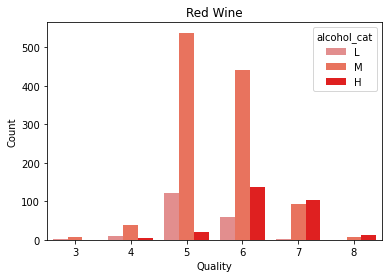

In [ ]:
sns.countplot(data=data_red, x="quality", hue='alcohol_cat', hue_order=order, palette={'L':"lightcoral",'M':"tomato",'H':"red"})
plt.title("Red Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

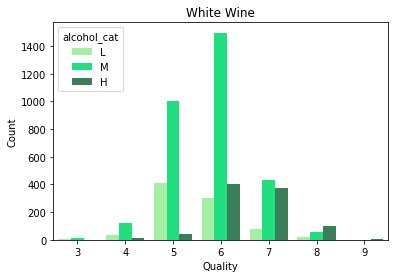

In [ ]:
sns.countplot(data=data_white, x="quality", hue='alcohol_cat', hue_order=order, palette={'L':"palegreen",'M':"springgreen",'H':"seagreen"})
plt.title("White Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

You can see that higher alcohol content seems to correspond with higher quality.

### Discretise Residual Sugar Content

Similar to the discretisation of the alcohol content, now you need to discretise the residual sugar content to a category of "sweet" or "dry". However, you don't have a specific value to seperate it. The only request is to split them almost evenly, as that will give you two balanced classes for your classifier.



#### Find the threshold

A good way to understand the numerical features is to use a box plot. A box plot is a graphical rendition of statistical data based on the minimum, first quartile, median, third quartile, and maximum.

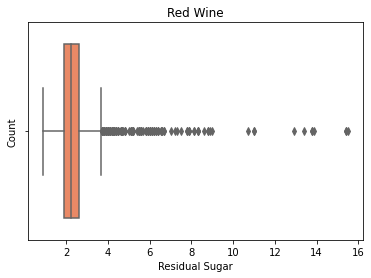

In [ ]:
sns.boxplot(data=data_red, x='residual sugar', color='coral')
plt.title("Red Wine")
plt.xlabel("Residual Sugar")
plt.ylabel("Count")
plt.show()
plt.close()

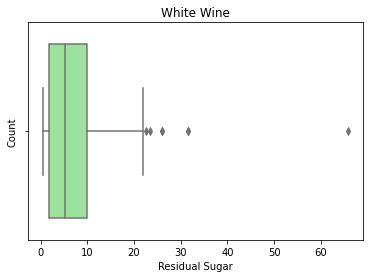

In [ ]:
sns.boxplot(data=data_white, x='residual sugar', color='lightgreen')
plt.title("White Wine")
plt.xlabel("Residual Sugar")
plt.ylabel("Count")
plt.show()
plt.close()

#### Split and Review

Simply, you can split the datasets by creating a binary column isSweet and using the median value as the threshold, which should give you two approximately even classes. The function used here is in `helpers.py` file.

In [ ]:
discreteSugar(data_red)
discreteSugar(data_white)

Now you can check the result to make sure the datasets are evenly splitted.

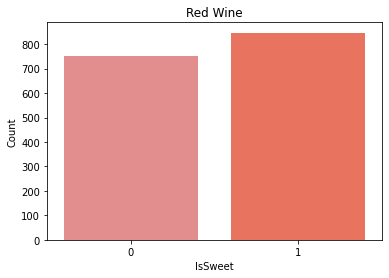

In [ ]:
sns.countplot(data=data_red, x="isSweet", palette={0:"lightcoral",1:"tomato"})
plt.title("Red Wine")
plt.xlabel("IsSweet")
plt.ylabel("Count")
plt.show()
plt.close()

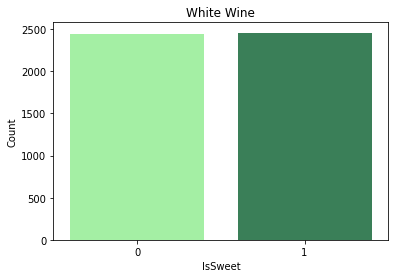

In [ ]:
sns.countplot(data=data_white, x="isSweet", palette={0:"palegreen",1:"seagreen"})
plt.title("White Wine")
plt.xlabel("IsSweet")
plt.ylabel("Count")
plt.show()
plt.close()

### Relationship Between Quality and Residual Sugar Content

After you discretise residual column, you can re-see the distribution of wine quality but seperately for different residual sugar content.

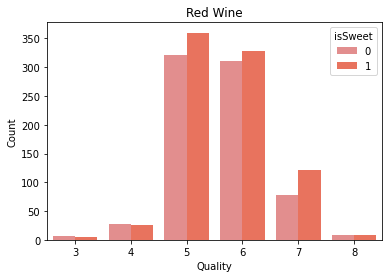

In [ ]:
order = [0, 1]
sns.countplot(data=data_red, x="quality", hue='isSweet', hue_order=order, palette={0:"lightcoral",1:"tomato"})
plt.title("Red Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

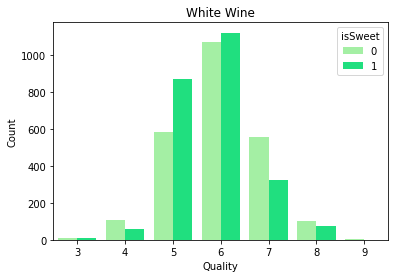

In [ ]:
sns.countplot(data=data_white, x="quality", hue='isSweet', hue_order=order, palette={0:"palegreen", 1:"springgreen"})
plt.title("White Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

As you can see, sweeter red wines are of better quality, but it's not true for white wines.

## Variable Correlation

Now you should have a basic understanding on the datasets. Next step is to determine which subset of the wine variables can be most useful for learning. To achieve this, you need to analyse correlations between:

* Each pair of variables
* Each variable and outcome (quality)



### Red Wine

First let's analyse the correlations in the red wine table.

#### Correlations in Variable Pairs

First you can use the `regplot` provided in `seaborn` to analyse it. The purpose of the regplot is to overlay the scatter points with a linear regression model, which can reveal the relationship trends between the variables.

The code snippet is logically same in each comparison. Reapeat comparisons in previous slot have been removed for each slot.

##### Fixed Acidity against Others

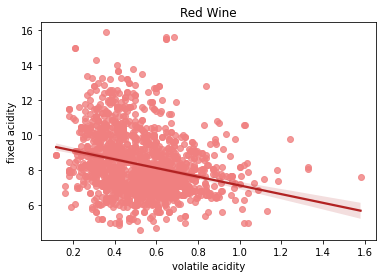

In [ ]:
sns.regplot(data=data_red, x="volatile acidity", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

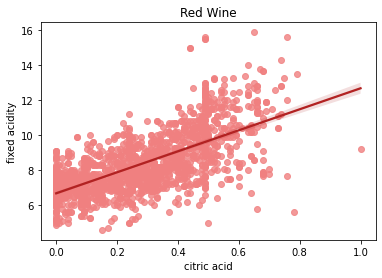

In [ ]:
sns.regplot(data=data_red, x="citric acid", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

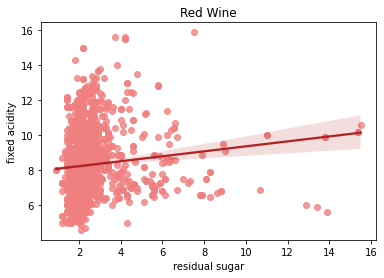

In [ ]:
sns.regplot(data=data_red, x="residual sugar", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

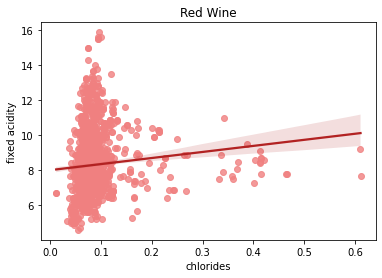

In [ ]:
sns.regplot(data=data_red, x="chlorides", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

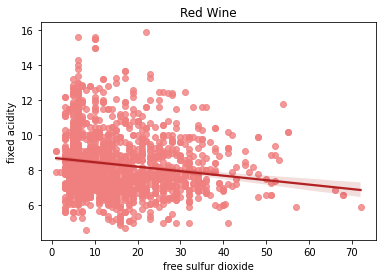

In [ ]:
sns.regplot(data=data_red, x="free sulfur dioxide", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

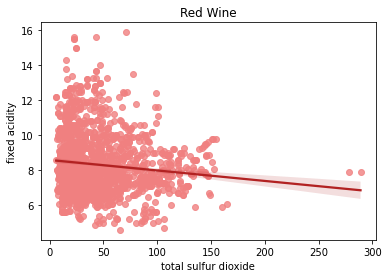

In [ ]:
sns.regplot(data=data_red, x="total sulfur dioxide", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

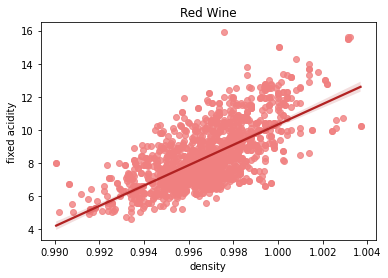

In [ ]:
sns.regplot(data=data_red, x="density", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

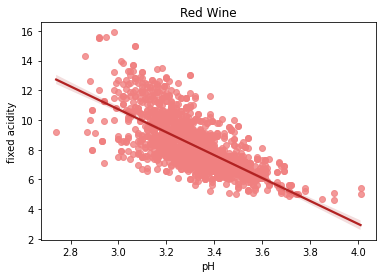

In [ ]:
sns.regplot(data=data_red, x="pH", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

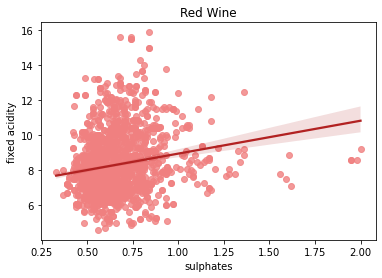

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

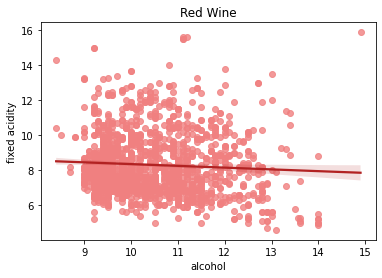

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="fixed acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Volatile Acidity against Others (Duplicates Excluded)

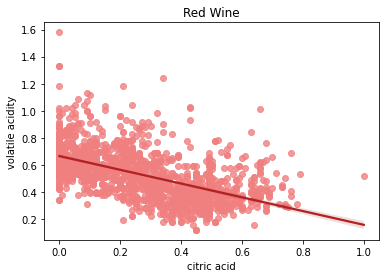

In [ ]:
sns.regplot(data=data_red, x="citric acid", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

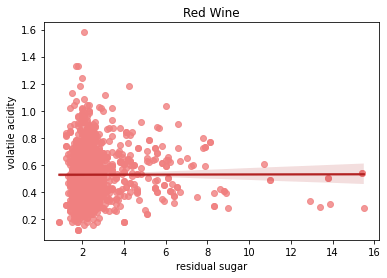

In [ ]:
sns.regplot(data=data_red, x="residual sugar", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

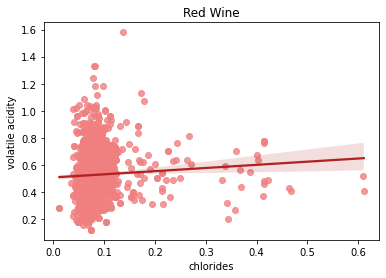

In [ ]:
sns.regplot(data=data_red, x="chlorides", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

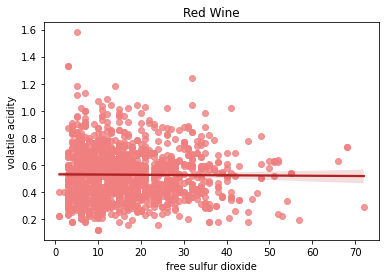

In [ ]:
sns.regplot(data=data_red, x="free sulfur dioxide", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

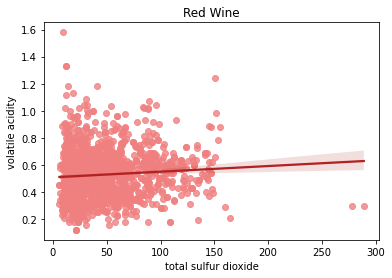

In [ ]:
sns.regplot(data=data_red, x="total sulfur dioxide", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

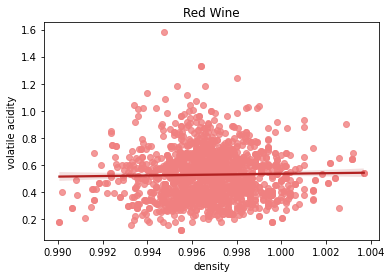

In [ ]:
sns.regplot(data=data_red, x="density", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

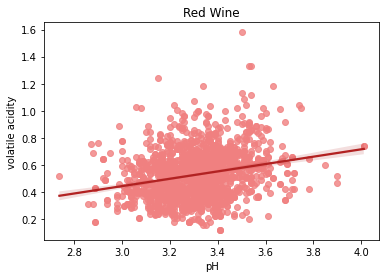

In [ ]:
sns.regplot(data=data_red, x="pH", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

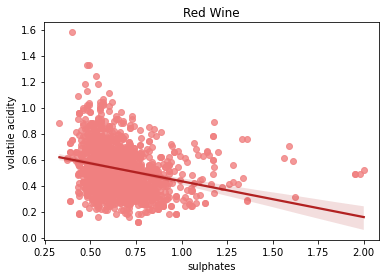

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

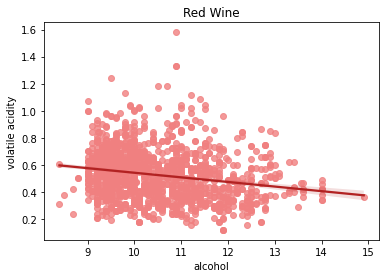

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="volatile acidity", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Citric Acid against Others (Duplicate Excluded)

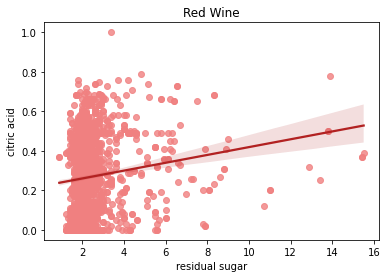

In [ ]:
sns.regplot(data=data_red, x="residual sugar", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

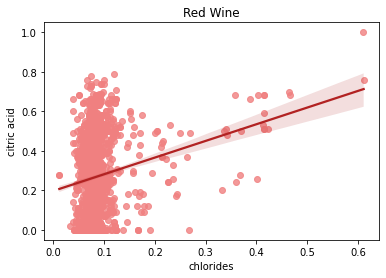

In [ ]:
sns.regplot(data=data_red, x="chlorides", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

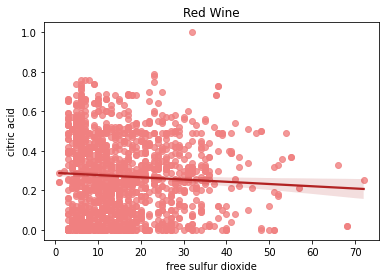

In [ ]:
sns.regplot(data=data_red, x="free sulfur dioxide", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

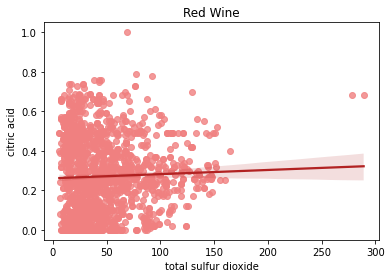

In [ ]:
sns.regplot(data=data_red, x="total sulfur dioxide", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

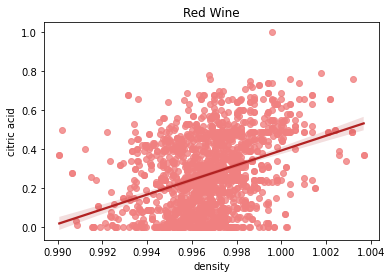

In [ ]:
sns.regplot(data=data_red, x="density", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

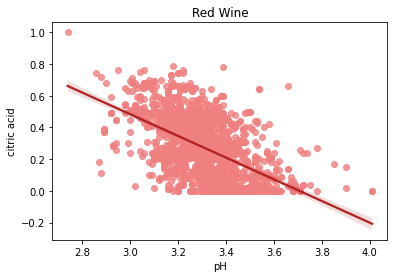

In [ ]:
sns.regplot(data=data_red, x="pH", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

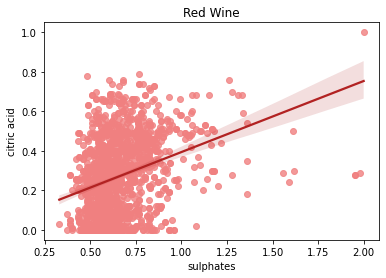

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

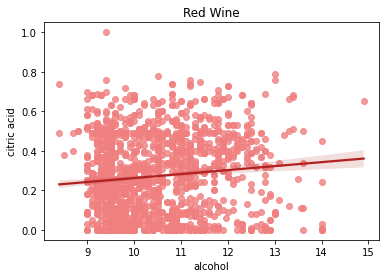

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="citric acid", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Residual Sugar against Others (Duplicate Excluded)

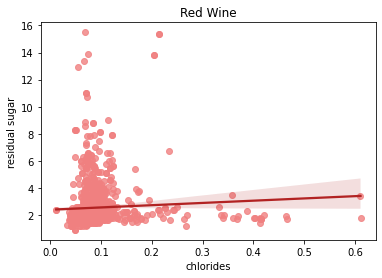

In [ ]:
sns.regplot(data=data_red, x="chlorides", y="residual sugar", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

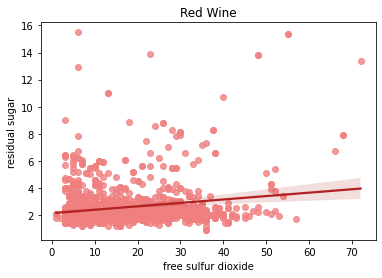

In [ ]:
sns.regplot(data=data_red, x="free sulfur dioxide", y="residual sugar", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

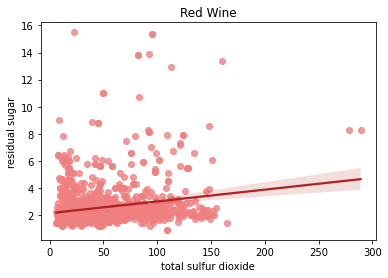

In [ ]:
sns.regplot(data=data_red, x="total sulfur dioxide", y="residual sugar", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

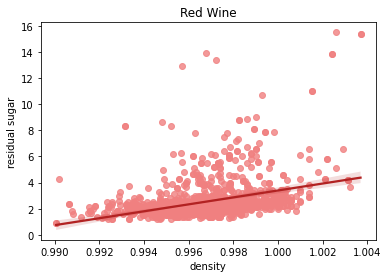

In [ ]:
sns.regplot(data=data_red, x="density", y="residual sugar", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

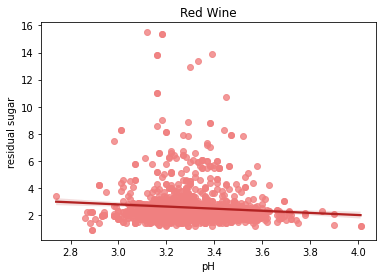

In [ ]:
sns.regplot(data=data_red, x="pH", y="residual sugar", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

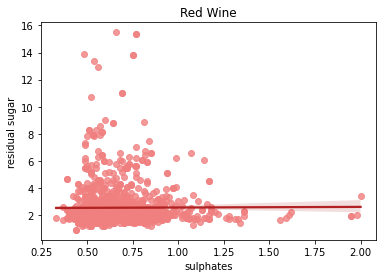

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="residual sugar", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

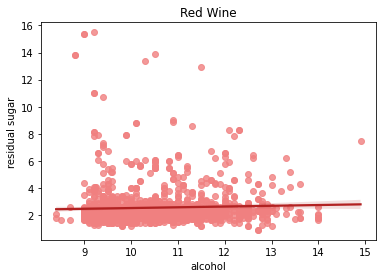

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="residual sugar", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Chlorides against Others (Duplicates Excluded)

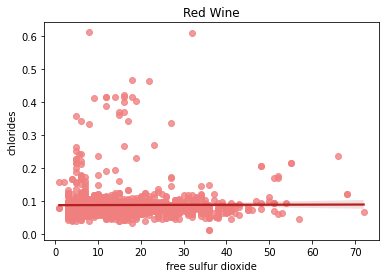

In [ ]:
sns.regplot(data=data_red, x="free sulfur dioxide", y="chlorides", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

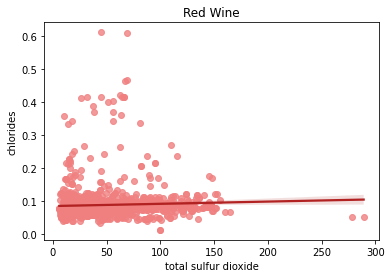

In [ ]:
sns.regplot(data=data_red, x="total sulfur dioxide", y="chlorides", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

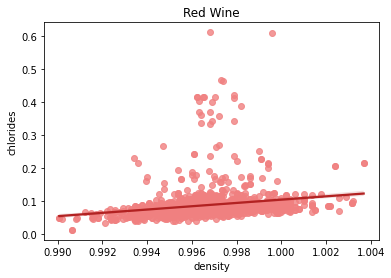

In [ ]:
sns.regplot(data=data_red, x="density", y="chlorides", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

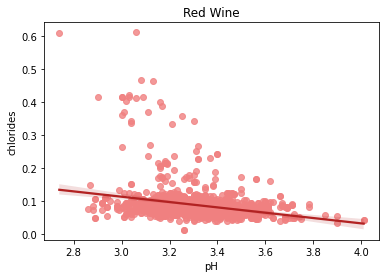

In [ ]:
sns.regplot(data=data_red, x="pH", y="chlorides", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

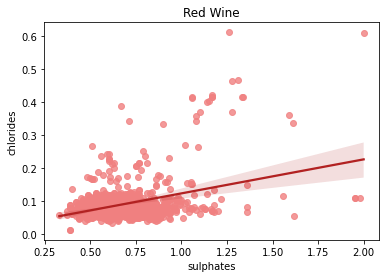

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="chlorides", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

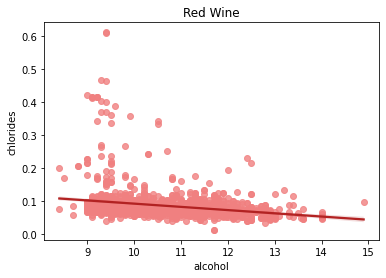

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="chlorides", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Free Sulfur Dioxide against Others (Duplicate Excluded)

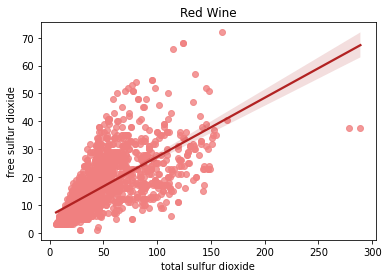

In [ ]:
sns.regplot(data=data_red, x="total sulfur dioxide", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

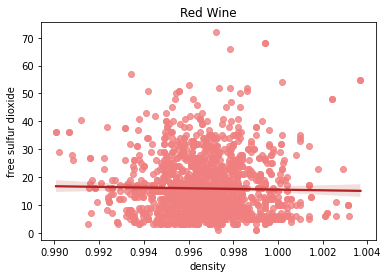

In [ ]:
sns.regplot(data=data_red, x="density", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

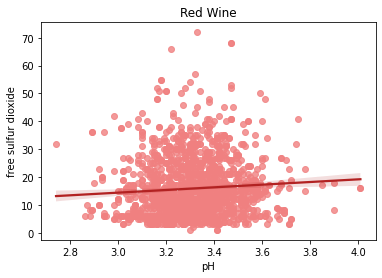

In [ ]:
sns.regplot(data=data_red, x="pH", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

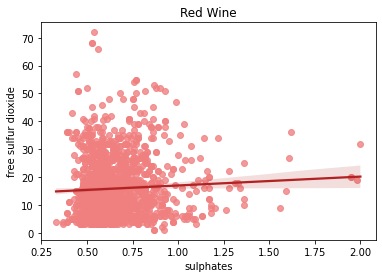

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

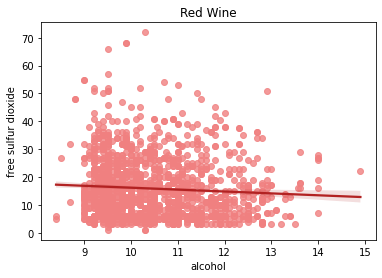

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Total Sulfur Dioxide against Others (Duplicates Excluded)

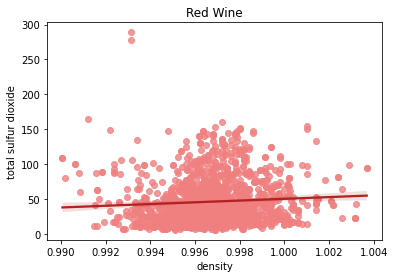

In [ ]:
sns.regplot(data=data_red, x="density", y="total sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

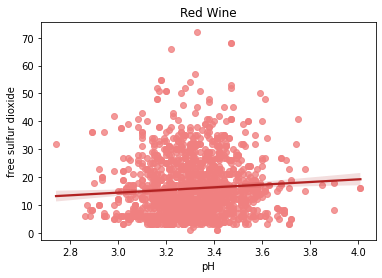

In [ ]:
sns.regplot(data=data_red, x="pH", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

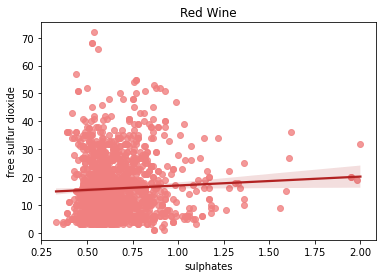

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

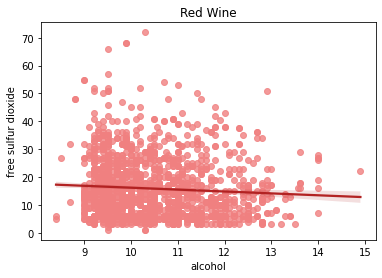

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="free sulfur dioxide", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Density against Others (Duplicates Excluded)

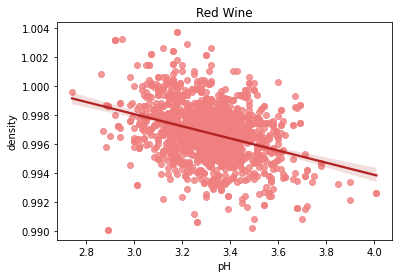

In [ ]:
sns.regplot(data=data_red, x="pH", y="density", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

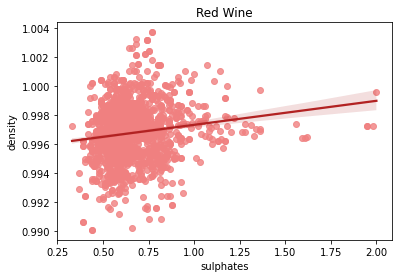

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="density", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

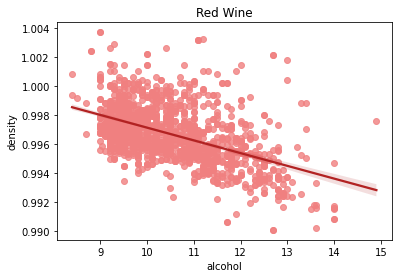

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="density", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### PH against Others (Duplicates Excluded)

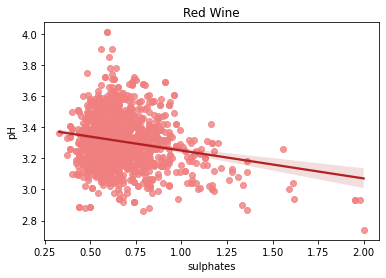

In [ ]:
sns.regplot(data=data_red, x="sulphates", y="pH", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

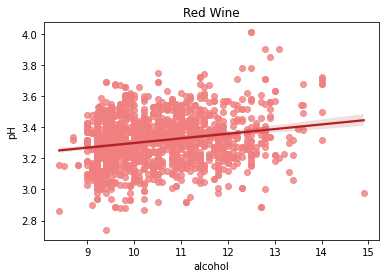

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="pH", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

##### Sulphates against Others (Duplicates Excluded)

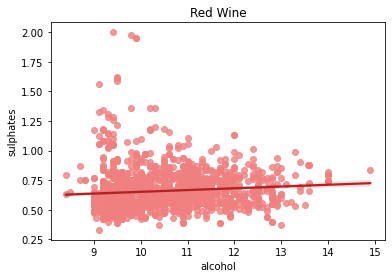

In [ ]:
sns.regplot(data=data_red, x="alcohol", y="sulphates", scatter_kws={"color":"lightcoral"}, line_kws={"color":"firebrick"}).set(title = "Red Wine")
plt.show()
plt.close()

#### Correlation between variable and quality

Now you should have a taste what relations among these variables. You can then analyse the relationship between each variable and quality. The `catplot` can describe the distribution of the variable in each column of the quality. 

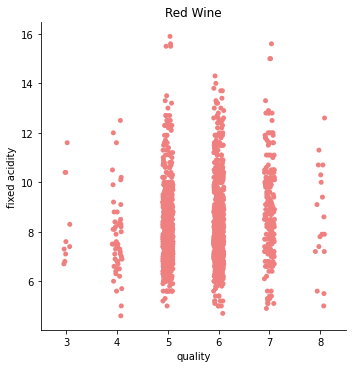

In [ ]:
sns.catplot(data=data_red, x="quality", y="fixed acidity", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

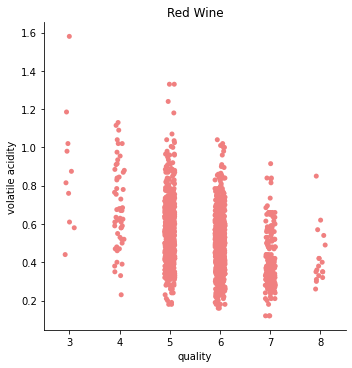

In [ ]:
sns.catplot(data=data_red, x="quality", y="volatile acidity", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

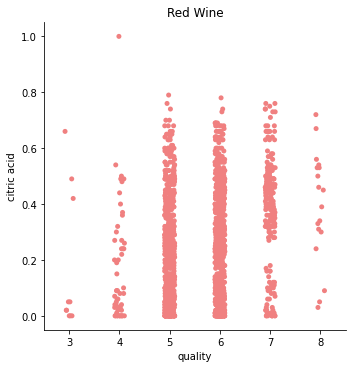

In [ ]:
sns.catplot(data=data_red, x="quality", y="citric acid", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

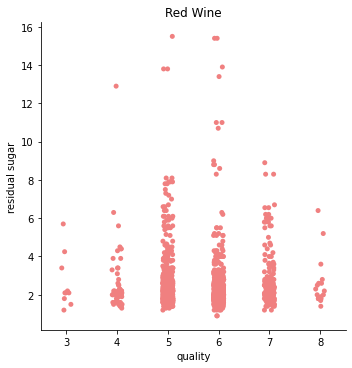

In [ ]:
sns.catplot(data=data_red, x="quality", y="residual sugar", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

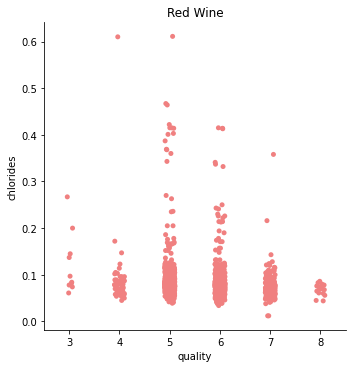

In [ ]:
sns.catplot(data=data_red, x="quality", y="chlorides", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

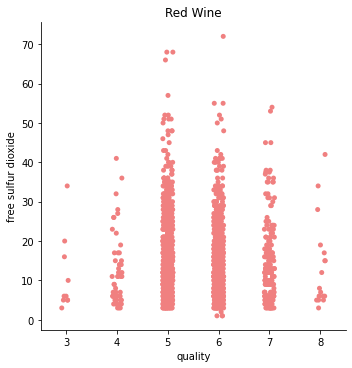

In [ ]:
sns.catplot(data=data_red, x="quality", y="free sulfur dioxide", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

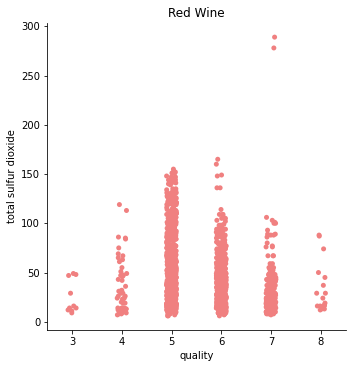

In [ ]:
sns.catplot(data=data_red, x="quality", y="total sulfur dioxide", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

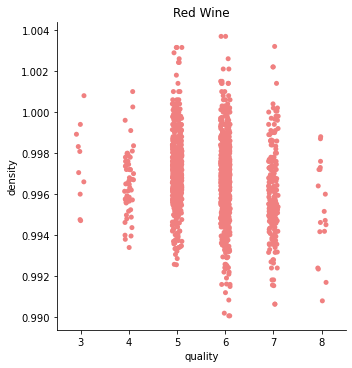

In [ ]:
sns.catplot(data=data_red, x="quality", y="density", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

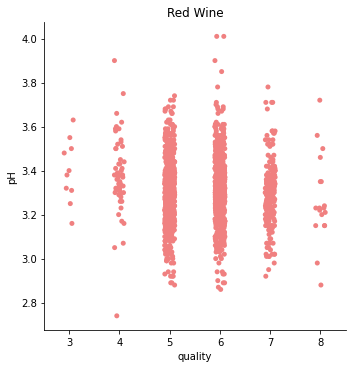

In [ ]:
sns.catplot(data=data_red, x="quality", y="pH", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

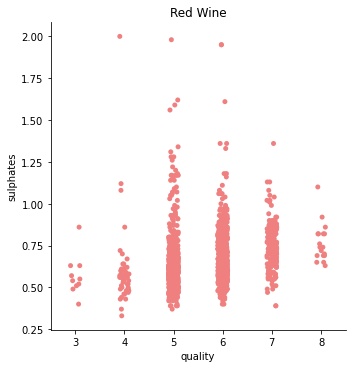

In [ ]:
sns.catplot(data=data_red, x="quality", y="sulphates", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

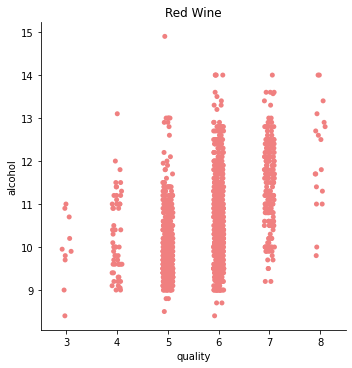

In [ ]:
sns.catplot(data=data_red, x="quality", y="alcohol", color="lightcoral").set(title = "Red Wine")
plt.show()
plt.close()

#### Correlation Matrix

The initial analysis gives us a basic view of the correlations but not suffcient to generate a conclusion. So you need to make a correlation matrix which can be way clear and integrated.

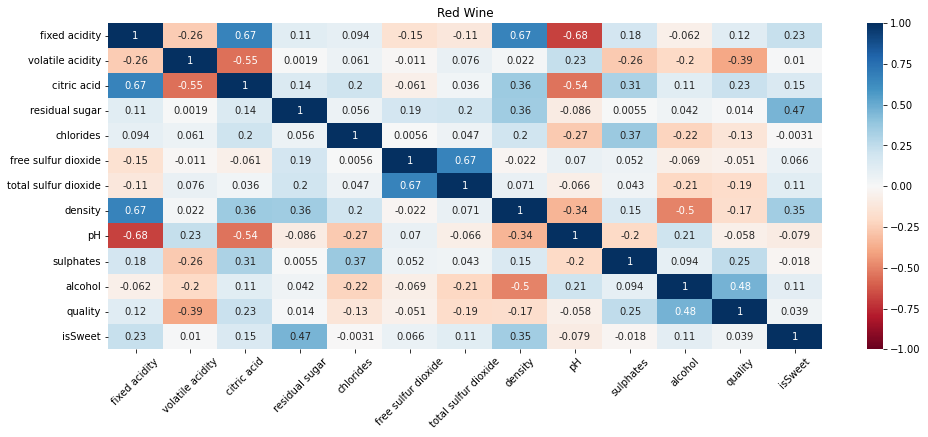

In [ ]:
plt.figure(figsize=(16, 6))
sns.heatmap(data_red.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdBu').set(title = "Red Wine")
plt.xticks(rotation=45)
plt.show()
plt.close()

### White wine

Then let's analyse the correlations in the white wine table with the same previous methods.


#### Correlations in Variable pairs

Same methods used as red wine. You can try it by yourself.

#### Correlations between variables and quality

Same methods used as red wine. You can try it by yourself.

#### Correlation Matrix

Here is the correlation matrix of white wine.

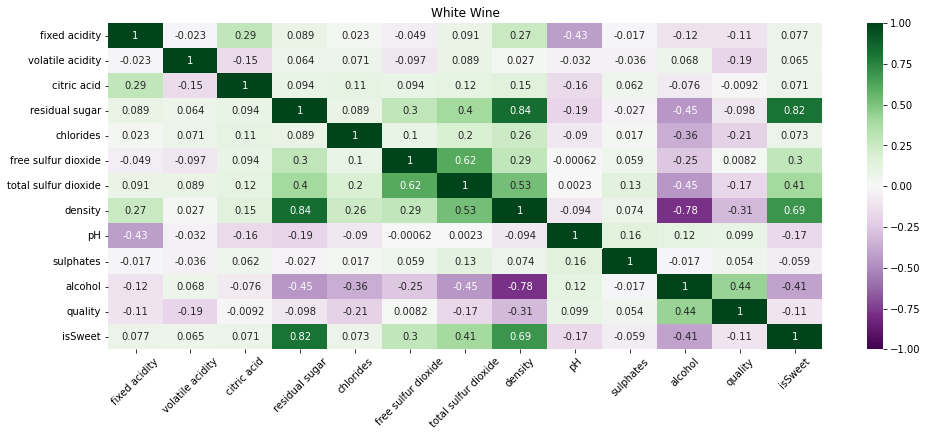

In [ ]:
plt.figure(figsize=(16, 6))
sns.heatmap(data_white.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='PRGn').set(title = "White Wine")
plt.xticks(rotation=45)
plt.show()
plt.close()

### Conclusion

The subset you are going to use is based on following principles:

* Using two variables that are highly correlated with each other is redundant.
* Using variables that are uncorrelated with the outcome is generally not useful.
* Using variables that have very small variance across the training set is not useful.

According to the previous analysis, for red wine:

* Residual sugar has lowest correlation with quality so removed
* Free sulfur dioxide has relatively low correlation with quality and highest correlation with total sulfur dioxide so removed
* PH has relatively low correlation with quality and lowest correlation with fixed acidity so removed

for white wine:

* Citric acid has lowest correlation with quality so removed
* Residual sugar has relatively low correlation with quality and highest correlation with density so removed
* Free sulfur dioxide has relatively low correlation with quality and high correlation with total sulfur dioxide so removed

## Machine Learning Experiment

### Classification Model

Consider the predictive model for quality as a classification problem, which means you need to reduce the classification labels to two labels representing high or low.

#### Preprocessing datasets

Before you really do the experiment, you need to do some preprocessing works on the datasets.


##### Drop Irrelevant Variables

Based on the conclusion in part 2, irrelevant columns need to be droped from the datasets.

In [ ]:
data_red_prep = data_red.drop(["residual sugar", "free sulfur dioxide", 'pH', "alcohol_cat", "isSweet"], axis=1)
data_white_prep = data_white.drop(["residual sugar", "free sulfur dioxide", 'citric acid', "alcohol_cat", "isSweet"], axis=1)
display(data_red_prep.head())
display(data_white_prep.head())

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,5
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,5
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,6
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5


,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.045,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.049,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.050,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.058,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.058,186.0,0.9956,3.19,0.40,9.9,6


##### Converting Quality into Binary variable

First you can set the threshold to 6 then you can try another later by simply change the variable value.

In [ ]:
data_red_prep = data_red_prep.rename(columns={"quality":"quality_cat"})
threshold = 6
for index, series in data_red_prep.iterrows():
    quality = series["quality_cat"]
    if quality < threshold:
        data_red_prep.loc[index, "quality_cat"] = 0
    else:
        data_red_prep.loc[index, "quality_cat"] = 1

data_white_prep = data_white_prep.rename(columns={"quality":"quality_cat"})
for index, series in data_white_prep.iterrows():
    quality = series["quality_cat"]
    if quality < threshold:
        data_white_prep.loc[index, "quality_cat"] = 0
    else:
        data_white_prep.loc[index, "quality_cat"] = 1

display(data_red_prep.head())
display(data_white_prep.head())

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,0
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,0
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,0
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,1
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,0


,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.045,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.049,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.050,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.058,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.058,186.0,0.9956,3.19,0.40,9.9,1


##### Splitting the Dataset

Before you go further, ensure you have a train set and test set. Before this, drop `quality_cat` from the dataset and assign it as label class. Test size is 33%.

In [ ]:
red_data = data_red_prep.drop(['quality_cat'], axis=1).values
red_labels = data_red_prep['quality_cat'].values
data_train_red, data_test_red, labels_train_red, labels_test_red = train_test_split(red_data, red_labels, test_size=0.33, random_state=10)

white_data = data_white_prep.drop(['quality_cat'], axis=1).values
white_labels = data_white_prep['quality_cat'].values
data_train_white, data_test_white, labels_train_white, labels_test_white = train_test_split(white_data, white_labels, test_size=0.33, random_state=10)

##### Oversampling the Dataset

Now you have datasets in a usable form to train a model on. But you still need to check the new train datasets to ensure there is no imbalance problem.

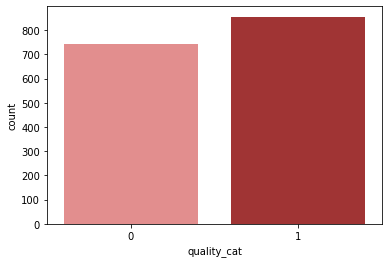

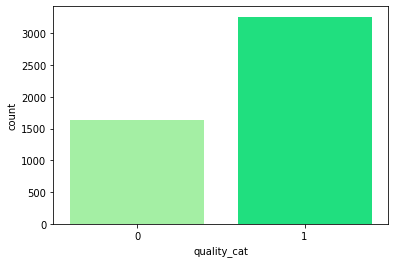

In [ ]:
sns.countplot(x="quality_cat", data=data_red_prep, palette={0:"lightcoral",1:"firebrick"})
plt.show()
plt.close()
sns.countplot(x="quality_cat", data=data_white_prep, palette={0:"palegreen",1:"springgreen"})
plt.show()
plt.close()

As you can see, there are imbalance problems in both red wine and white wine datasets. So you need to use SMOTE to oversampling the train sets.

In [ ]:
smote = SMOTE(random_state=10)

data_train_red, labels_train_red = smote.fit_resample(data_train_red, labels_train_red)
data_train_white, labels_train_white = smote.fit_resample(data_train_white, labels_train_white)

##### Scaling the data

Now you have balanced datasets. Last step is to scale the datasets based on the train sets' values.

In [ ]:
scaler = StandardScaler()

scaler.fit(data_train_red)
data_train_scaled_red = scaler.transform(data_train_red)
data_test_scaled_red = scaler.transform(data_test_red)

scaler.fit(data_train_white)
data_train_scaled_white = scaler.transform(data_train_white)
data_test_scaled_white = scaler.transform(data_test_white)

#### Training Model

Due to the limited physical resource of my PC, you will only see the solution of the red wine prediction, which uses smaller datasets. But the logic of the code is identical. You can try the white wine by simply changing the dataset objects.

##### Non-linear SVM

First let's try training a non-linear SVM model.


In [ ]:
non_linear_svm = SVC(kernel='poly', degree=10, C=100, coef0=9, random_state=10)

clf = non_linear_svm.fit(data_train_scaled_red, labels_train_red)
non_linear_svm_predictions_test = non_linear_svm.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, non_linear_svm_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
non_linear_svm_predictions_train = non_linear_svm.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, non_linear_svm_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 72.1590909090909%
Train acc for red wine: 100.0%


Based on the result, we are almost certainly overfitting. We can tell this because of the 100% training accuracy, but only 72.16% accuracy on the test set. You need to perform some hyperparameter tuning using cross validation on the non-linear SVM to try to reduce the overfitting.

In [ ]:
number_of_folds = 5
random_state = 10
parameters_to_tune = [{'kernel': ['poly', 'rbf'],
                      'C': [1, 10],
                      'degree': [1, 40], 
                      'coef0': [1, 9]}]

search = GridSearchCV(SVC(random_state = random_state), parameters_to_tune, cv = number_of_folds)

search.fit(data_train_scaled_red, labels_train_red)
print(f"Best parameters set found for red wine: {search.best_params_}")

In [ ]:
non_linear_svm = SVC(kernel = search.best_params_['kernel'],
            degree = search.best_params_['degree'],
            C = search.best_params_['C'],
            coef0 = search.best_params_['coef0'], 
            random_state = 10)
clf = non_linear_svm.fit(data_train_scaled_red, labels_train_red)
non_linear_svm_predictions_test = non_linear_svm.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, non_linear_svm_predictions)
print(f"Test acc for red wine: {test_acc_red * 100}%")
non_linear_svm_predictions_train = non_linear_svm.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, non_linear_svm_predictions)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Due to the limited physical resource of my pc, this task is extremely time-consuming. But the code should perform the task pretty well, that the new hyperparameters should reduce the overfitting.

##### Evaluation on Non-linear SVM

After training the model you need to evaluate the performance of the model. A binary classifier can be evaluated using f1-score, ROC curves, AUC. A brief prediction report can also be generated to make the conclusion more clear.

Non-linear SVM:

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       1.00      1.00      1.00       580

    accuracy                           1.00      1160
   macro avg       1.00      1.00      1.00      1160
weighted avg       1.00      1.00      1.00      1160

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       253
           1       0.73      0.73      0.73       275

    accuracy                           0.72       528
   macro avg       0.72      0.72      0.72       528
weighted avg       0.72      0.72      0.72       528

Cross-validation scores
Training set: 0.73 (± 0.06)
Test set: 0.67 (± 0.02)


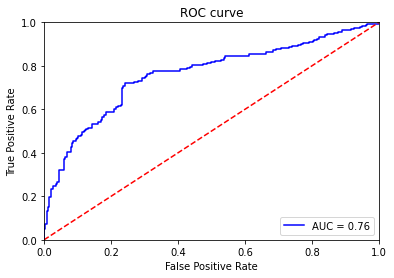

In [ ]:
print('Non-linear SVM:\n')
print('Train Set Predictions Report:\n')
print(classification_report(labels_train_red, non_linear_svm_predictions_train))
print('Test Set Predictions Report:\n')
print(classification_report(labels_test_red, non_linear_svm_predictions_test))

print("Cross-validation scores")
scores = cross_val_score(clf, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

plotROC(clf, data_test_scaled_red, labels_test_red, probs=False)

##### Decision Trees and Random Forests

Now let's try training a decision trees model.

In [ ]:
decision_tree = tree.DecisionTreeClassifier(random_state = 10)

clf_tree = decision_tree.fit(data_train_scaled_red, labels_train_red)
decision_tree_predictions_test = decision_tree.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, decision_tree_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
decision_tree_predictions_train = decision_tree.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, decision_tree_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 72.53787878787878%
Train acc for red wine: 100.0%


One again, you observe overfitting. In fact, decisions trees are so prone to overfitting it is rare to see them used on their own. One way to reduce their overfitting is to train multiple differnt decisions trees and then use these to vote on the final result. This is known as a random forest, as the model consists of an ensamble of randomly generated decision trees. Let's take a look at building one of these.

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50, max_depth=50, random_state=10)

clf_forest = random_forest.fit(data_train_scaled_red, labels_train_red)
random_forest_predictions_test = random_forest.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, random_forest_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
random_forest_predictions_train = random_forest.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, random_forest_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 78.78787878787878%
Train acc for red wine: 100.0%


Perform a hyperparameter search since there may be still an overfitting.

In [ ]:
random_state = 10
number_of_folds = 5
parameters_to_tune = [{'n_estimators': [10, 100],
                      'max_depth': [5, 100]}]

search = GridSearchCV(RandomForestClassifier(random_state = random_state), parameters_to_tune, cv = number_of_folds)
search.fit(data_train_scaled_red, labels_train_red)

print(f"Best parameters set found for random forest: {search.best_params_}")

random_forest = RandomForestClassifier(n_estimators=search.best_params_['n_estimators'],
                                       max_depth=search.best_params_['max_depth'],
                                       random_state=10)

clf_forest = random_forest.fit(data_train_scaled_red, labels_train_red)
random_forest_predictions_test = random_forest.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, random_forest_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
random_forest_predictions_train = random_forest.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, random_forest_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Best parameters set found for random forest: {'max_depth': 100, 'n_estimators': 100}
Test acc for red wine: 79.16666666666666%
Train acc for red wine: 100.0%


Now you can see the test accuracy has very slightly increased - suggesting you have prevented overfitting and produced a generalised model. Again, with a larger hyperparameter search you may be able to do better here.

##### Evaluation on Decision Trees and Random Forest

Decision Trees:

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       1.00      1.00      1.00       580

    accuracy                           1.00      1160
   macro avg       1.00      1.00      1.00      1160
weighted avg       1.00      1.00      1.00      1160

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       253
           1       0.74      0.72      0.73       275

    accuracy                           0.73       528
   macro avg       0.73      0.73      0.73       528
weighted avg       0.73      0.73      0.73       528

Cross-validation scores
Training set: 0.72 (± 0.03)
Test set: 0.70 (± 0.03)


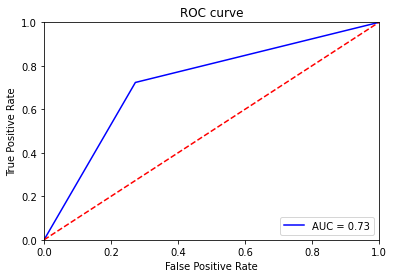

In [ ]:
print('Decision Trees:\n')
print('Train Set Predictions Report:\n')
print(classification_report(labels_train_red, decision_tree_predictions_train))
print('Test Set Predictions Report:\n')
print(classification_report(labels_test_red, decision_tree_predictions_test))

print("Cross-validation scores")
scores = cross_val_score(clf_tree, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf_tree, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

plotROC(clf_tree, data_test_scaled_red, labels_test_red)

Random Forest:

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       1.00      1.00      1.00       580

    accuracy                           1.00      1160
   macro avg       1.00      1.00      1.00      1160
weighted avg       1.00      1.00      1.00      1160

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       253
           1       0.80      0.79      0.80       275

    accuracy                           0.79       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.79      0.79      0.79       528

Cross-validation scores
Training set: 0.79 (± 0.04)
Test set: 0.76 (± 0.04)


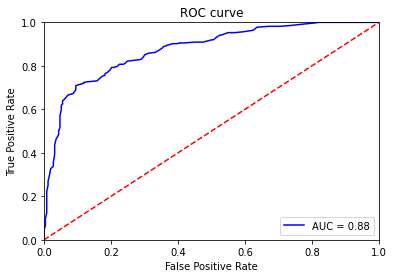

In [ ]:
print('Random Forest:\n')
print('Train Set Predictions Report:\n')
print(classification_report(labels_train_red, random_forest_predictions_train))
print('Test Set Predictions Report:\n')
print(classification_report(labels_test_red, random_forest_predictions_test))

print("Cross-validation scores")
scores = cross_val_score(clf_forest, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf_forest, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

plotROC(clf_forest, data_test_scaled_red, labels_test_red)

##### KNN 

Now let's try KNeighbors model.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=200)

clf_knn = knn.fit(data_train_scaled_red, labels_train_red)
knn_predictions_test = knn.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, knn_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
knn_predictions_train = knn.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, knn_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 75.18939393939394%
Train acc for red wine: 74.74137931034483%


##### Evaluation on KNN

KNN:

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.73      0.78      0.76       580
           1       0.77      0.71      0.74       580

    accuracy                           0.75      1160
   macro avg       0.75      0.75      0.75      1160
weighted avg       0.75      0.75      0.75      1160

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       253
           1       0.77      0.75      0.76       275

    accuracy                           0.75       528
   macro avg       0.75      0.75      0.75       528
weighted avg       0.75      0.75      0.75       528

Cross-validation scores
Training set: 0.72 (± 0.02)
Test set: 0.71 (± 0.08)


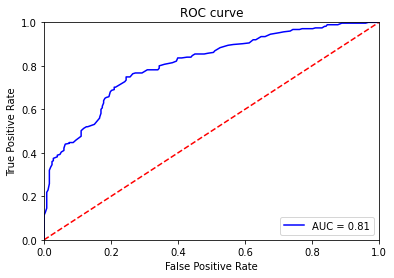

In [ ]:
print('KNN:\n')
print('Train Set Predictions Report:\n')
print(classification_report(labels_train_red, knn_predictions_train))
print('Test Set Predictions Report:\n')
print(classification_report(labels_test_red, knn_predictions_test))

print("Cross-validation scores")
scores = cross_val_score(clf_knn, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf_knn, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

plotROC(clf_knn, data_test_scaled_red, labels_test_red)

### Regression Model

Consider the predictive model as a regression problem, which quality now is a continuous variable.

#### Preprocessing Datasets

Basically same with the classification model, except don't convert quality variable. Besides, SMOTE are not used here since oversampling is not appropriate.

In [ ]:
data_red_prep = data_red.drop(["residual sugar", "free sulfur dioxide", 'pH', "alcohol_cat", "isSweet"], axis=1)
data_white_prep = data_white.drop(["residual sugar", "free sulfur dioxide", 'citric acid', "alcohol_cat", "isSweet"], axis=1)
display(data_red_prep.head())
display(data_white_prep.head())

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,5
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,5
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,6
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5


,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.045,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.049,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.050,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.058,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.058,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
red_data = data_red_prep.drop(['quality'], axis=1).values
red_labels = data_red_prep['quality'].values
data_train_red, data_test_red, labels_train_red, labels_test_red = train_test_split(red_data, red_labels, test_size=0.33, random_state=10)

white_data = data_white_prep.drop(['quality'], axis=1).values
white_labels = data_white_prep['quality'].values
data_train_white, data_test_white, labels_train_white, labels_test_white = train_test_split(white_data, white_labels, test_size=0.33, random_state=10)

In [ ]:
scaler = StandardScaler()

scaler.fit(data_train_red)
data_train_scaled_red = scaler.transform(data_train_red)
data_test_scaled_red = scaler.transform(data_test_red)

scaler.fit(data_train_white)
data_train_scaled_white = scaler.transform(data_train_white)
data_test_scaled_white = scaler.transform(data_test_white)

#### Training Models

##### Logistic Regression

In [ ]:
l_r = LogisticRegression(penalty='l2',C=1,solver='lbfgs',multi_class='ovr')

clf_l_r = l_r.fit(data_train_scaled_red, labels_train_red)
l_r_predictions_test = l_r.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, l_r_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
l_r_predictions_train = l_r.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, l_r_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 57.38636363636363%
Train acc for red wine: 60.97105508870215%


##### Evaluation on Logistic Regression

You can use MSE, RMSE to evaluation regression model.

In [ ]:
print('Logistic Regression:\n')

print("Cross-validation scores")
scores = cross_val_score(clf_l_r, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf_l_r, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})\n")

print("MSE: ", mean_squared_error(labels_test_red, l_r_predictions_test))
print("RMSE: ", np.sqrt(mean_squared_error(labels_test_red, l_r_predictions_test)))

Logistic Regression:

Cross-validation scores
Training set: 0.61 (± 0.03)
Test set: 0.57 (± 0.05)

MSE:  0.5435606060606061
RMSE:  0.7372656278849612


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


##### Non-linear SVM

In [ ]:
non_linear_svm = SVC(kernel='poly', degree=10, C=100, coef0=9, random_state=10)

clf = non_linear_svm.fit(data_train_scaled_red, labels_train_red)
non_linear_svm_predictions_test = non_linear_svm.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, non_linear_svm_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
non_linear_svm_predictions_train = non_linear_svm.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, non_linear_svm_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 58.71212121212122%
Train acc for red wine: 100.0%


##### Evaluation on Non-linear SVM

In [ ]:
print('Non-linear SVM:\n')

print("Cross-validation scores")
scores = cross_val_score(clf, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})\n")

print("MSE: ", mean_squared_error(labels_test_red, non_linear_svm_predictions_test))
print("RMSE: ", np.sqrt(mean_squared_error(labels_test_red, non_linear_svm_predictions_test)))

Non-linear SVM:

Cross-validation scores
Training set: 0.56 (± 0.03)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


Test set: 0.48 (± 0.02)

MSE:  0.6685606060606061
RMSE:  0.8176555546564862


##### Decision Trees

In [ ]:
decision_tree = tree.DecisionTreeClassifier(random_state = 10)

clf_tree = decision_tree.fit(data_train_scaled_red, labels_train_red)
decision_tree_predictions_test = decision_tree.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, decision_tree_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
decision_tree_predictions_train = decision_tree.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, decision_tree_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 59.09090909090909%
Train acc for red wine: 100.0%


##### Evaluation on Decision Trees

In [ ]:
print('Decision Trees:\n')

print("Cross-validation scores")
scores = cross_val_score(clf_tree, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf_tree, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})\n")

print("MSE: ", mean_squared_error(labels_test_red, decision_tree_predictions_test))
print("RMSE: ", np.sqrt(mean_squared_error(labels_test_red, decision_tree_predictions_test)))

Decision Trees:

Cross-validation scores
Training set: 0.57 (± 0.03)
Test set: 0.51 (± 0.09)

MSE:  0.6571969696969697
RMSE:  0.8106768589869638


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


##### Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50, max_depth=50, random_state=10)

clf_forest = random_forest.fit(data_train_scaled_red, labels_train_red)
random_forest_predictions_test = random_forest.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, random_forest_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
random_forest_predictions_train = random_forest.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, random_forest_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 65.3409090909091%
Train acc for red wine: 100.0%


##### Evaluation on Random Forest

In [ ]:
print('Random Forest:\n')

print("Cross-validation scores")
scores = cross_val_score(clf_forest, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf_forest, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})\n")

print("MSE: ", mean_squared_error(labels_test_red, random_forest_predictions_test))
print("RMSE: ", np.sqrt(mean_squared_error(labels_test_red, random_forest_predictions_test)))

Random Forest:

Cross-validation scores
Training set: 0.65 (± 0.02)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


Test set: 0.58 (± 0.01)

MSE:  0.45454545454545453
RMSE:  0.674199862463242


##### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=200)

clf_knn = knn.fit(data_train_scaled_red, labels_train_red)
knn_predictions_test = knn.predict(data_test_scaled_red)
test_acc_red = accuracy_score(labels_test_red, knn_predictions_test)
print(f"Test acc for red wine: {test_acc_red * 100}%")
knn_predictions_train = knn.predict(data_train_scaled_red)
train_acc_red = accuracy_score(labels_train_red, knn_predictions_train)
print(f"Train acc for red wine: {train_acc_red * 100}%")

Test acc for red wine: 57.95454545454546%
Train acc for red wine: 58.730158730158735%


##### Evaluation on KNN

In [ ]:
print('KNN:\n')

print("Cross-validation scores")
scores = cross_val_score(clf_knn, data_train_scaled_red, labels_train_red, cv=3)
print(f"Training set: {scores.mean():.2f} (± {scores.std() * 2:.2f})")
scores = cross_val_score(clf_knn, data_test_scaled_red, labels_test_red, cv=3)
print(f"Test set: {scores.mean():.2f} (± {scores.std() * 2:.2f})\n")

print("MSE: ", mean_squared_error(labels_test_red, knn_predictions_test))
print("RMSE: ", np.sqrt(mean_squared_error(labels_test_red, knn_predictions_test)))

KNN:

Cross-validation scores
Training set: 0.58 (± 0.05)
Test set: 0.51 (± 0.05)

MSE:  0.5378787878787878
RMSE:  0.7334022006230877


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,
